# ==============================================================================
# TUGAS UTS: TOPIC MODELING (LDA)
# NAMA:Abdurrahman Gofiky
# DATASET: Shopee Reviews (SHOPEE_REVIEWS.csv)
# ==============================================================================

# ------------------------------------------------------------------------------
# 1. PENJELASAN DATASET - IMPORT LIBRARIES
# ------------------------------------------------------------------------------

In [1]:
print("Mengimpor library...")
import pandas as pd
import numpy as np
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import warnings

Mengimpor library...


In [2]:
# Mengabaikan peringatan agar output bersih
warnings.filterwarnings('ignore')

In [3]:
# Download resource NLTK (hanya perlu dijalankan sekali)
print("Mengunduh resource NLTK...")
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpus/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

Mengunduh resource NLTK...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Setting untuk visualisasi
plt.style.use('ggplot')
sns.set(style='whitegrid')
print("Import library selesai.\n")

Import library selesai.



## 1. Penjelasan Dataset

Kasus yang diambil:
Analisis topik (Topic Modeling) pada dataset ulasan aplikasi Shopee dari Google Play Store untuk menemukan tema-tema atau keluhan utama yang dibicarakan pengguna.

Penjelasan Kolom:
* `content`: Teks lengkap dari ulasan pengguna (ini adalah data input kita).
* `score`: Rating yang diberikan pengguna (1-5), akan digunakan untuk Data Understanding.

In [5]:
# ------------------------------------------------------------------------------
# 1. PENJELASAN DATASET - LOAD DATA
# ------------------------------------------------------------------------------
print("Memuat data 'SHOPEE_REVIEWS.csv'...")
try:
    # Ganti nama file jika berbeda
    df = pd.read_csv('SHOPEE_REVIEWS.csv')
    print("Data berhasil dimuat.")
    display(df.head())
except FileNotFoundError:
    print("\n--- PENTING ---")
    print("Error: File 'SHOPEE_REVIEWS.csv' tidak ditemukan.")
    print("Silakan upload file tersebut ke environment Colab/Jupyter Anda.")
    print("---------------")
    # Membuat DataFrame kosong agar sisa notebook tidak error
    df = pd.DataFrame(columns=['content', 'score'])

Memuat data 'SHOPEE_REVIEWS.csv'...
Data berhasil dimuat.


,Unnamed: 0,review_text,review_rating,author_id,author_name,author_app_version,review_datetime_utc,review_likes
0,0,The next level in buying and selling! Everyone...,5,111458*********009852,A Google user,NaN,2015-06-22T02:35:03.000Z,1
1,1,User friendly ecommerce site.,5,112264*********945160,A Google user,1.8.66,2015-06-22T02:56:13.000Z,3
2,2,This is such a cool app. I find it easy to bro...,5,109502*********169058,A Google user,1.8.66,2015-06-22T02:57:41.000Z,2
3,3,"Finally, they're here! Hooray!",5,110132*********773079,A Google user,1.8.66,2015-06-22T03:21:24.000Z,1
4,4,"Very cool app. Shop anytime, anywhere. Hassle-...",5,108961*********895535,A Google user,1.8.66,2015-06-22T08:21:15.000Z,1


## 2. Data Understanding

Jumlah total baris data: 782079
Panjang rata-rata review (karakter): 50.09
Jumlah data duplikasi (berdasarkan review): 301289
Jumlah data setelah hapus duplikasi: 480549

Jumlah data kosong (NA) per kolom:
Unnamed: 0                  0
review_text                 0
review_rating               0
author_id                   1
author_name                 0
author_app_version     110669
review_datetime_utc         0
review_likes                0
length                      0
dtype: int64

Menampilkan visualisasi distribusi skor (rating)...


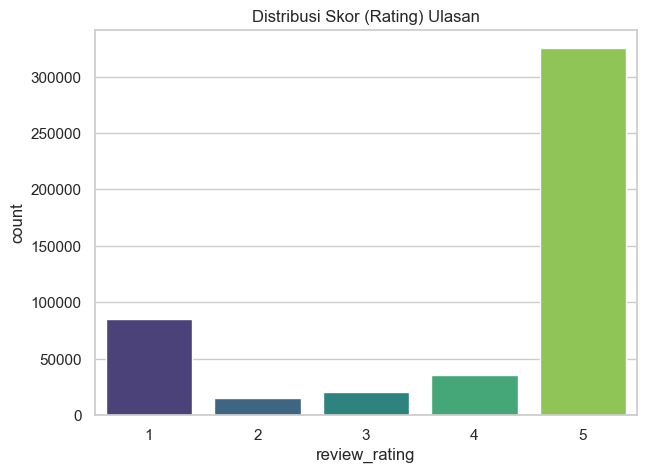

In [6]:
# ------------------------------------------------------------------------------
# 2. DATA UNDERSTANDING
# ------------------------------------------------------------------------------
if df.empty:
    print("DataFrame kosong. Langkah Data Understanding dilewati.")
else:
    # 1. Jumlah baris data
    print(f"Jumlah total baris data: {len(df)}")
    
    # 2. Panjang rata-rata setiap baris (review)
    # GANTI 'content' -> 'review_text'
    df = df.dropna(subset=['review_text']) 
    df['length'] = df['review_text'].astype(str).apply(len)
    print(f"Panjang rata-rata review (karakter): {df['length'].mean():.2f}")
    
    # 3. Cek data duplikasi (berdasarkan konten review)
    # GANTI 'content' -> 'review_text'
    print(f"Jumlah data duplikasi (berdasarkan review): {df.duplicated(subset=['review_text']).sum()}")
    df = df.drop_duplicates(subset=['review_text'])
    print(f"Jumlah data setelah hapus duplikasi: {len(df)}")
    
    # 4. Cek data kosong (seharusnya sudah 0 setelah dropna)
    print("\nJumlah data kosong (NA) per kolom:")
    print(df.isnull().sum())
    
    # 5. Distribusi data (Bar chart untuk score)
    print("\nMenampilkan visualisasi distribusi skor (rating)...")
    plt.figure(figsize=(7, 5))
    # GANTI 'score' -> 'review_rating'
    sns.countplot(x='review_rating', data=df, palette='viridis') 
    plt.title('Distribusi Skor (Rating) Ulasan')
    plt.show()

Menampilkan WordCloud (sebelum processing)...


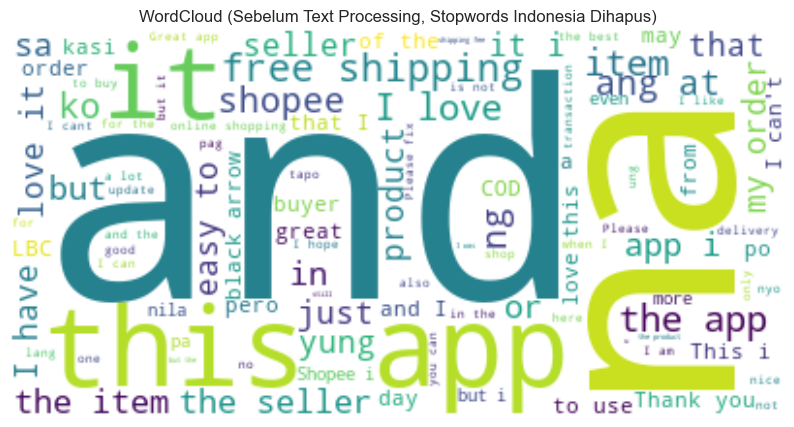

In [7]:
# 5. Distribusi data (Word cloud kata yang sering muncul)
if not df.empty:
    print("Menampilkan WordCloud (sebelum processing)...")
    # Menggunakan 'review_text'
    text = " ".join(review for review in df['review_text'].head(10000))
    
    # Dapatkan stopwords bahasa Indonesia
    stop_words_id = set(stopwords.words('indonesian'))
    
    wordcloud = WordCloud(stopwords=stop_words_id, max_words=100, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("WordCloud (Sebelum Text Processing, Stopwords Indonesia Dihapus)")
    plt.show()

## 3. Data Text Processing

In [8]:
# ------------------------------------------------------------------------------
# 3. DATA TEXT PROCESSING (Bahasa Indonesia)
# ------------------------------------------------------------------------------

# Inisialisasi NLTK tools (stopwords)
stop_words_id = set(stopwords.words('indonesian'))

# Tambahkan stopwords Bahasa Inggris (karena ulasan Anda juga banyak B. Inggris)
stop_words_en = set(stopwords.words('english'))
stop_words_id.update(stop_words_en)

# Tambahkan kata-kata custom (Tagalog/Filipina) yang ingin Anda hapus
# (Saya tambahkan dari "Topik #2" Anda)
custom_stopwords = set(['ang', 'mga', 'ako', 'yung', 'naman', 'hindi', 'mag', 'shipping', 'ng', 'po', 'ko', 'may', 'pero', 'nyo', 'wala', 'nag', 'maganda', 'pag','lang'])
stop_words_id.update(custom_stopwords)

# Inisialisasi Sastrawi Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def preprocess_text_id(text):
    # 5. Normalisasi: Hapus tag HTML (jika ada)
    text = re.sub(r'<.*?>', ' ', str(text)) # Tambahkan str() untuk keamanan
    
    # 4. Normalisasi: Hapus non-huruf dan ubah ke lowercase (case folding)
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    
    # 1. Tokenisasi
    tokens = word_tokenize(text)
    
    processed_tokens = []
    for token in tokens:
        # 4. Stopword removal (kata) & 4. Hapus token pendek
        if token not in stop_words_id and len(token) > 2:
            # 3. Stemming (menggunakan Sastrawi)
            token = stemmer.stem(token)
            processed_tokens.append(token)
            
    # Gabungkan kembali menjadi string
    return " ".join(processed_tokens)

if df.empty:
    print("DataFrame kosong. Langkah Text Processing dilewati.")
    df_sample = pd.DataFrame(columns=['review_text', 'processed_text'])
else:
    # Terapkan fungsi
    # CATATAN: Kita gunakan 10000 data agar proses cepat untuk pengumpulan tugas.
    print("Memulai text processing (Bahasa Indonesia)...")
    # Ambil sampel acak 10000 data
    df_sample = df.sample(n=10000, random_state=42).copy()
    
    # Menggunakan 'review_text'
    df_sample['processed_text'] = df_sample['review_text'].apply(preprocess_text_id)
    print("Text processing selesai.")
    
    # Tampilkan hasil
    print("\nContoh hasil processing:")
    # Menggunakan 'review_text'
    display(df_sample[['review_text', 'processed_text']].head())

Memulai text processing (Bahasa Indonesia)...
Text processing selesai.

Contoh hasil processing:


,review_text,processed_text
244395,Use friendly and very helpful to online seller...,use friendly helpful online sellers like
646025,"very very bad customer service, restricting ac...",bad customer service restricting account viola...
437898,This is my go to app when shopping. Most of al...,app shopping support great items legit
637056,"after the update, shopee no longer allows us t...",update shopee longer allows use free voucher d...
355823,"not friendly user, why do you always put free ...",friendly user always put free shopee pay users...


In [13]:
# ------------------------------------------------------------------------------
# 3. DATA TEXT PROCESSING - VEKTORISASI
# ------------------------------------------------------------------------------
print("Membuat Document-Term Matrix (DTM) dengan CountVectorizer...")
# 7. Text Vektorisasi
vectorizer = CountVectorizer(max_features=1000, min_df=5, max_df=0.95)

if df_sample.empty or df_sample['processed_text'].isnull().all():
    print("Tidak ada data yang diproses. Langkah Vektorisasi dilewati.")
    dtm = None
else:
    dtm = vectorizer.fit_transform(df_sample['processed_text'])
    print(f"Shape dari Document-Term Matrix (DTM): {dtm.shape}")
    print(f"Jumlah dokumen: {dtm.shape[0]}, Jumlah kata unik (fitur): {dtm.shape[1]}")

Membuat Document-Term Matrix (DTM) dengan CountVectorizer...
Shape dari Document-Term Matrix (DTM): (10000, 1000)
Jumlah dokumen: 10000, Jumlah kata unik (fitur): 1000


## 4. Data Modeling (LDA)

**Penjelasan Model:**
Untuk menemukan topik-topik tersembunyi dari data ulasan Shopee ini, kita akan menggunakan model **Latent Dirichlet Allocation (LDA)**.

**Mengapa LDA?**
LDA adalah model probabilistik yang paling umum digunakan untuk *topic modeling*. Model ini berasumsi bahwa setiap dokumen (ulasan) merupakan campuran dari berbagai topik, dan setiap topik merupakan campuran dari berbagai kata. Model ini cocok untuk mengidentifikasi keluhan atau pujian umum (topik) dari ribuan ulasan.

**Parameter yang Digunakan:**
* `n_components=5`: Ini adalah parameter utama yang menentukan jumlah topik yang ingin kita temukan. Kita akan mencoba mencari 5 topik utama.
* `random_state=42`: Digunakan agar hasil yang didapat konsisten.

In [10]:
# ------------------------------------------------------------------------------
# 4. DATA MODELING - IMPLEMENTASI
# ------------------------------------------------------------------------------
if dtm is None:
    print("DTM tidak ada. Langkah Modeling dilewati.")
    lda = None
else:
    # Tentukan jumlah topik
    n_topics = 5

    # Inisialisasi dan latih model LDA
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=10,
        learning_method='batch'
    )

    print(f"Melatih model LDA dengan {n_topics} topik...")
    lda.fit(dtm)
    print("Pelatihan model LDA selesai.")

Melatih model LDA dengan 5 topik...
Pelatihan model LDA selesai.


## 5. Visualisasi Topic

--- Top 10 Kata per Topik ---
Topik #1: nice, shopee, order, good, delivery, ung, seller, item, lahat, apps

Topik #2: free, shopee, good, vouchers, voucher, order, use, pay, fee, delivery

Topik #3: seller, shopee, service, customer, star, order, account, cant, refund, item

Topik #4: app, good, love, items, great, easy, really, use, buy, always

Topik #5: shopee, shopping, online, shop, app, best, thank, salamat, great, enjoy



Menampilkan visualisasi distribusi topik dominan...


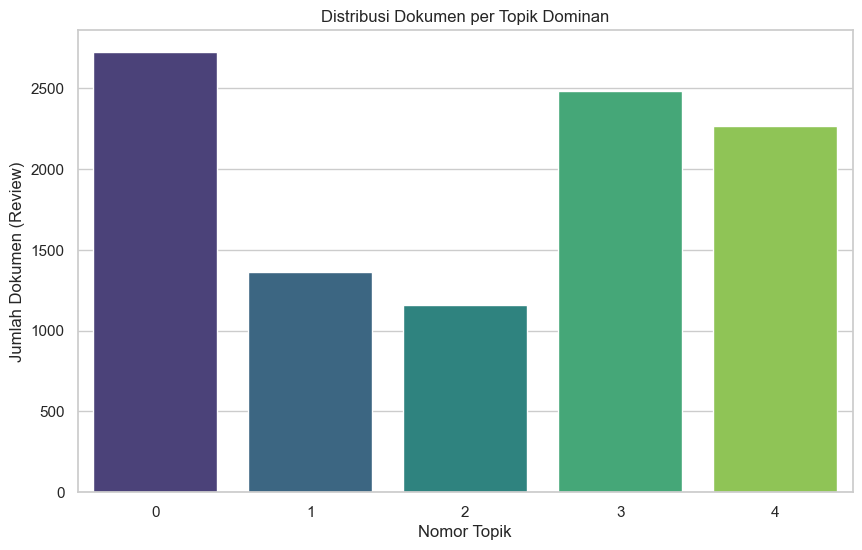

In [11]:
# ------------------------------------------------------------------------------
# 5. VISUALISASI TOPIC
# ------------------------------------------------------------------------------
if lda is None:
    print("Model LDA tidak dilatih. Langkah Visualisasi dilewati.")
else:
    def display_topics(model, feature_names, no_top_words):
        print(f"--- Top {no_top_words} Kata per Topik ---")
        for topic_idx, topic in enumerate(model.components_):
            message = f"Topik #{topic_idx+1}: "
            message += ", ".join([feature_names[i]
                                for i in topic.argsort()[:-no_top_words - 1:-1]])
            print(message)
            print("") # Baris baru

    # Ambil nama fitur (kata-kata) dari vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Tampilkan 10 kata teratas per topik
    display_topics(lda, feature_names, 10)
    print("\n")

    # Visualisasi Distribusi Topik Dominan
    print("Menampilkan visualisasi distribusi topik dominan...")
    topic_results = lda.transform(dtm)
    df_sample['dominant_topic'] = topic_results.argmax(axis=1)

    plt.figure(figsize=(10, 6))
    sns.countplot(x='dominant_topic', data=df_sample, palette='viridis')
    plt.title('Distribusi Dokumen per Topik Dominan')
    plt.xlabel('Nomor Topik')
    plt.ylabel('Jumlah Dokumen (Review)')
    plt.show()

## 6. Implementasi T-SNE (Visualisasi Klaster)

Menggunakan t-SNE untuk memvisualisasikan pengelompokan topik dalam 2D.
Menjalankan t-SNE (mungkin butuh beberapa saat)...
t-SNE selesai.
Menampilkan plot t-SNE...


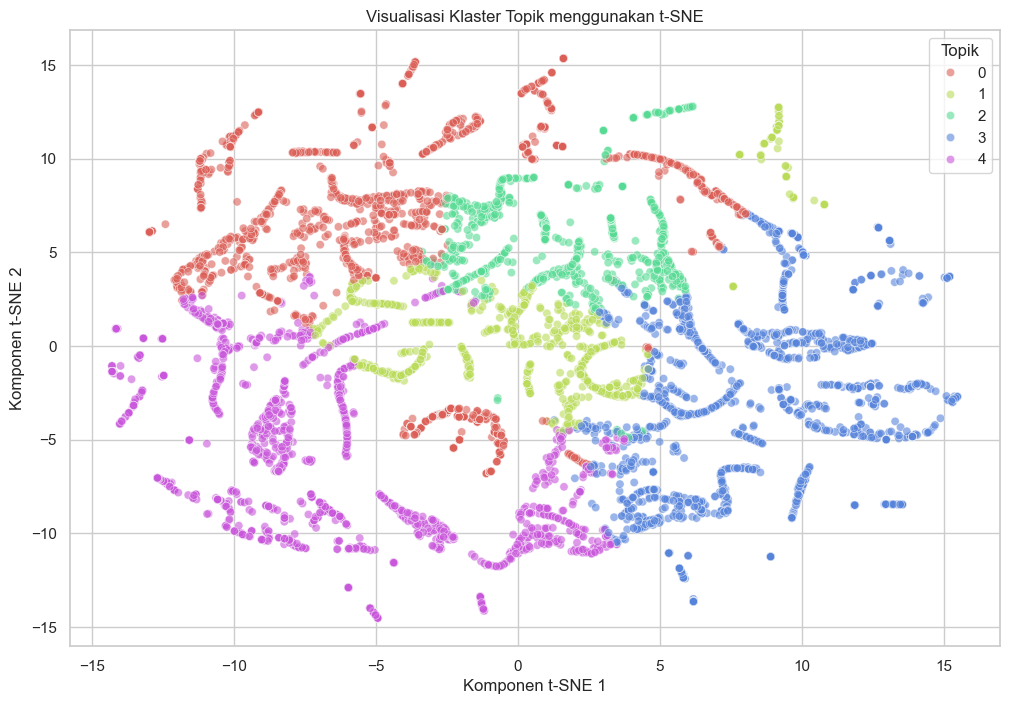

In [12]:
# ------------------------------------------------------------------------------
# 6. IMPLEMENTASI T-SNE (VISUALISASI KLASTER)
# ------------------------------------------------------------------------------
print("Menggunakan t-SNE untuk memvisualisasikan pengelompokan topik dalam 2D.")

if lda is None:
    print("Model LDA tidak dilatih. Langkah t-SNE dilewati.")
else:
    # Reduksi dimensi hasil LDA (distribusi topik) menjadi 2D menggunakan t-SNE
    
    # PERBAIKAN: Mengganti 'n_iter=300' menjadi 'max_iter=300'
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
    
    print("Menjalankan t-SNE (mungkin butuh beberapa saat)...")
    tsne_results = tsne.fit_transform(topic_results)
    print("t-SNE selesai.")

    # Membuat DataFrame untuk plotting
    df_tsne = pd.DataFrame({
        'tsne_A': tsne_results[:,0],
        'tsne_B': tsne_results[:,1],
        'topic': df_sample['dominant_topic']
    })

    # Plotting hasil t-SNE
    print("Menampilkan plot t-SNE...")
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x="tsne_A", y="tsne_B",
        hue="topic",
        palette=sns.color_palette("hls", n_topics),
        data=df_tsne,
        legend="full",
        alpha=0.6
    )
    plt.title('Visualisasi Klaster Topik menggunakan t-SNE')
    plt.xlabel('Komponen t-SNE 1')
    plt.ylabel('Komponen t-SNE 2')
    plt.legend(title='Topik')
    plt.show()